In [1]:
#pip install streamlit
#pip install streamlit-option-menu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [3]:
#lectura archivo consulta
df = pd.read_csv('consulta.csv', sep=',', encoding='latin-1')

In [4]:
df

,IdCategorias,categoria,precio,cuotas,medio_de_pago,payment_value,puntaje,IdCiudad,ciudad
0,1,agro_industria_e_comercio,19.50,1,credit_card,27.79,5,5514,sao paulo
1,1,agro_industria_e_comercio,429.00,6,credit_card,927.60,1,1707,curitiba
2,1,agro_industria_e_comercio,429.00,6,credit_card,927.60,1,1707,curitiba
3,1,agro_industria_e_comercio,495.60,1,debit_card,523.23,4,1362,caxias do sul
4,1,agro_industria_e_comercio,161.99,1,debit_card,182.68,4,1334,catanduva
...,...,...,...,...,...,...,...,...,...
113084,71,utilidades_domesticas,79.00,8,credit_card,97.13,5,4179,pedreira
113085,71,utilidades_domesticas,84.99,1,credit_card,103.86,5,5514,sao paulo
113086,71,utilidades_domesticas,34.20,1,boleto,101.60,5,5514,sao paulo
113087,71,utilidades_domesticas,34.20,1,boleto,101.60,5,5514,sao paulo


In [5]:
df['medio_de_pago'].unique()

array(['credit_card', 'debit_card', 'boleto', 'voucher'], dtype=object)

In [6]:
#eliminar columnas que no se usaran en el analisis categoria, y convertir medio_pago y ciudad en categoricas
df = df.drop(['categoria'], axis=1)
df=df.drop(['ciudad'], axis=1)
df = pd.get_dummies(df, columns=['medio_de_pago'])


In [7]:
df.columns

Index(['IdCategorias', 'precio', 'cuotas', 'payment_value', 'puntaje',
       'IdCiudad', 'medio_de_pago_boleto', 'medio_de_pago_credit_card',
       'medio_de_pago_debit_card', 'medio_de_pago_voucher'],
      dtype='object')

In [8]:
# uso de libreria xgboost en regresion para predecir la variable respuesta es payment_value, usaremos optuna para optimizar los hiperparametros y asi obtener el mejor modelo, luego guardar el modelo en un archivo pickle
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pickle

#separacion de variables independientes y dependientes
X = df.drop(['payment_value'], axis=1)
y = df['payment_value']

#separacion de datos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#funcion objetivo para optimizar hiperparametros

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True)
    param = {
        #'silent': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        #'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
        #'rate_drop': trial.suggest_float('rate_drop', 1e-8, 1.0),
        #'skip_drop': trial.suggest_float('skip_drop', 1e-8, 1.0),
        'tree_method': 'gpu_hist',
        'gpu_id': '0'
    }
    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    rmse = mean_squared_error(y_test, pred_labels, squared=False)
    return rmse

#optimizacion de hiperparametros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

#entrenamiento del modelo con los mejores hiperparametros
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = { #'silent': 1,
            'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'booster': study.best_trial.params['booster'],
            'lambda': study.best_trial.params['lambda'],
            'alpha': study.best_trial.params['alpha'],
            'max_depth': study.best_trial.params['max_depth'],
            'eta': study.best_trial.params['eta'],
            'gamma': study.best_trial.params['gamma'],
            'grow_policy': study.best_trial.params['grow_policy'],
            'subsample': study.best_trial.params['subsample'],
            'colsample_bytree': study.best_trial.params['colsample_bytree'],
            'min_child_weight': study.best_trial.params['min_child_weight'],
            'max_delta_step': study.best_trial.params['max_delta_step'],
            'sampling_method': study.best_trial.params['sampling_method'],
            #'normalize_type': study.best_trial.params['normalize_type'],
            #'rate_drop': study.best_trial.params['rate_drop'],
            #'skip_drop': study.best_trial.params['skip_drop'],
            'tree_method': 'gpu_hist',
            'gpu_id': '0'

            }
num_round = 100
bst = xgb.train(param, dtrain, num_round)

In [ ]:
#prediccion de datos de test
preds = bst.predict(dtest)
pred_labels = np.rint(preds)

#evaluacion del modelo
rmse = mean_squared_error(y_test, pred_labels, squared=False)
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(y_test, pred_labels)
print('MAE: %.3f' % mae)
r2 = r2_score(y_test, pred_labels)
print('R2: %.3f' % r2)

#guardar modelo en archivo pickle
pickle.dump(bst, open('model.pkl', 'wb'))

#grafico de importancia de variables
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

RMSE: 104.714
MAE: 49.377
R2: 0.836


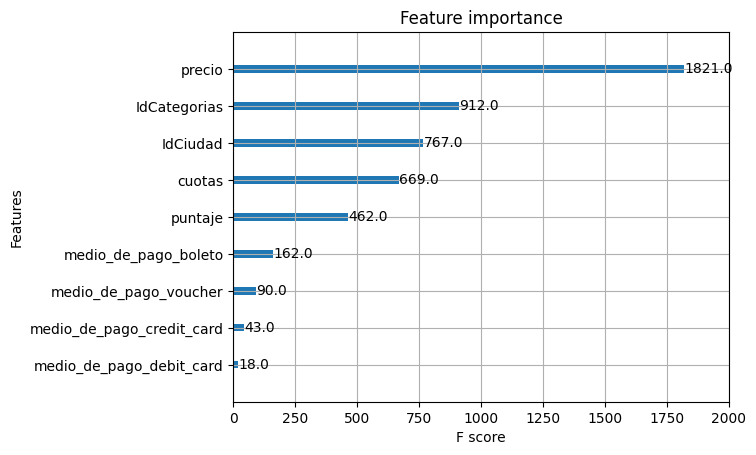

['model1.joblib']

In [11]:
# xgboost con scikit-learn
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

#entrenamiento del modelo
model = XGBRegressor()
model.fit(X_train, y_train)

#prediccion de datos de test
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

#evaluacion del modelo
rmse = mean_squared_error(y_test, predictions, squared=False)
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(y_test, predictions)
print('MAE: %.3f' % mae)
r2 = r2_score(y_test, predictions)
print('R2: %.3f' % r2)

#grafico de importancia de variables
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# guardar modelo en archivo joblib
from joblib import dump
dump(model, 'model1.joblib')


In [ ]:
#cargar modelo joblib
from joblib import load
model = load('model1.joblib')


In [14]:
# leer variabels de entrenamiento del modelo en joblib
model.get_booster().feature_names

['IdCategorias',
 'precio',
 'cuotas',
 'puntaje',
 'IdCiudad',
 'medio_de_pago_boleto',
 'medio_de_pago_credit_card',
 'medio_de_pago_debit_card',
 'medio_de_pago_voucher']

RMSE: 79.252
MAE: 35.860
R2: 0.906


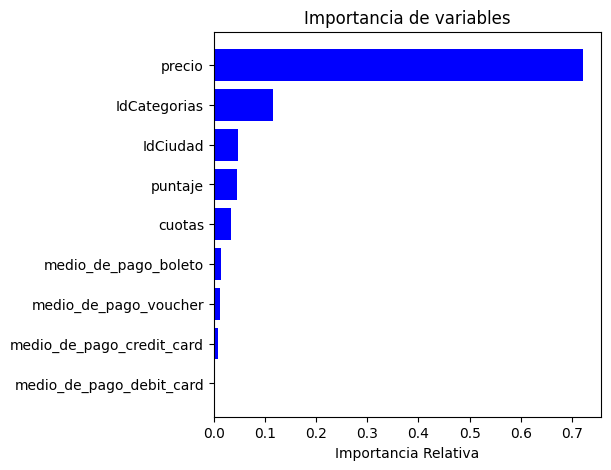

In [18]:
# Modelos Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

#entrenamiento del modelo
model = RandomForestRegressor()
model.fit(X_train, y_train)

#prediccion de datos de test
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

#evaluacion del modelo
rmse = mean_squared_error(y_test, predictions, squared=False)
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(y_test, predictions)
print('MAE: %.3f' % mae)
r2 = r2_score(y_test, predictions)
print('R2: %.3f' % r2)

#grafico de importancia de variables random forest y dale las etiquetas que corresponden a cada variable
importances = model.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.title('Importancia de variables')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()


# guardar modelo en archivo joblib
from joblib import dump
dump(model, 'model2.joblib')

# leer variables de entrenamiento del modelo random forest en joblib

model.feature_importances_

# cargar modelo joblib
from joblib import load
model = load('model2.joblib')
